In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import Image

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
def diagnostic_plots(y_pred, y_true):
    resid = y_pred - y_true
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

In [3]:
nfl_df = pd.read_csv('final_nfl.csv')

In [4]:
nfl_df.drop(columns = ['Unnamed: 0'], inplace=True)

In [5]:
nfl_df.head()

,Team,Year,1st Passing %,2nd Passing %,3rd Passing %,2nd Avg Yards to Go,3rd Avg Yards to Go,1st 1D Conversion %,2nd 1D Conversion %,3rd 1D Conversion %,Leading % Passing,Tied % Passing,Trailing % Passing,DVOA
0,Arizona Cardinals,1994,0.375000,0.509915,0.793860,8.51,8.07,0.192982,0.263456,0.337719,0.397380,0.451737,0.584369,-0.166
1,Arizona Cardinals,1995,0.436652,0.584570,0.768116,7.96,7.83,0.171946,0.299703,0.342995,0.559441,0.463415,0.584356,-0.237
2,Arizona Cardinals,1996,0.525386,0.552023,0.736842,8.04,7.24,0.185430,0.268786,0.421053,0.443966,0.513369,0.651200,-0.048
3,Arizona Cardinals,1997,0.543290,0.504323,0.669421,8.90,8.22,0.199134,0.230548,0.359504,0.477528,0.502283,0.600000,-0.138
4,Arizona Cardinals,1998,0.454936,0.505780,0.703196,7.57,6.99,0.203863,0.289017,0.347032,0.446203,0.498127,0.596567,-0.062


In [6]:
nfl_df.describe()

,Year,1st Passing %,2nd Passing %,3rd Passing %,2nd Avg Yards to Go,3rd Avg Yards to Go,1st 1D Conversion %,2nd 1D Conversion %,3rd 1D Conversion %,Leading % Passing,Tied % Passing,Trailing % Passing,DVOA
count,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000
mean,2007.159812,0.452302,0.525747,0.701940,7.961786,7.187955,0.197479,0.306462,0.386515,0.445109,0.506743,0.606640,-0.002442
std,7.738237,0.058139,0.062513,0.056476,0.344605,0.490037,0.029335,0.041375,0.050060,0.057439,0.058719,0.050284,0.142938
min,1994.000000,0.237986,0.272727,0.497608,6.960000,5.720000,0.115169,0.185668,0.238095,0.251969,0.337662,0.431907,-0.433000
25%,2001.000000,0.414347,0.482540,0.662499,7.730000,6.860000,0.177173,0.277699,0.354403,0.407849,0.465401,0.575265,-0.100000
50%,2007.000000,0.454167,0.528902,0.704082,7.950000,7.180000,0.195699,0.305195,0.384977,0.445880,0.505495,0.607293,-0.003000
75%,2014.000000,0.493318,0.568858,0.740385,8.200000,7.485000,0.217582,0.334380,0.421174,0.484848,0.545398,0.641467,0.091000
max,2020.000000,0.608696,0.723464,0.881579,9.160000,8.770000,0.314168,0.433022,0.567308,0.594272,0.689873,0.789340,0.441000


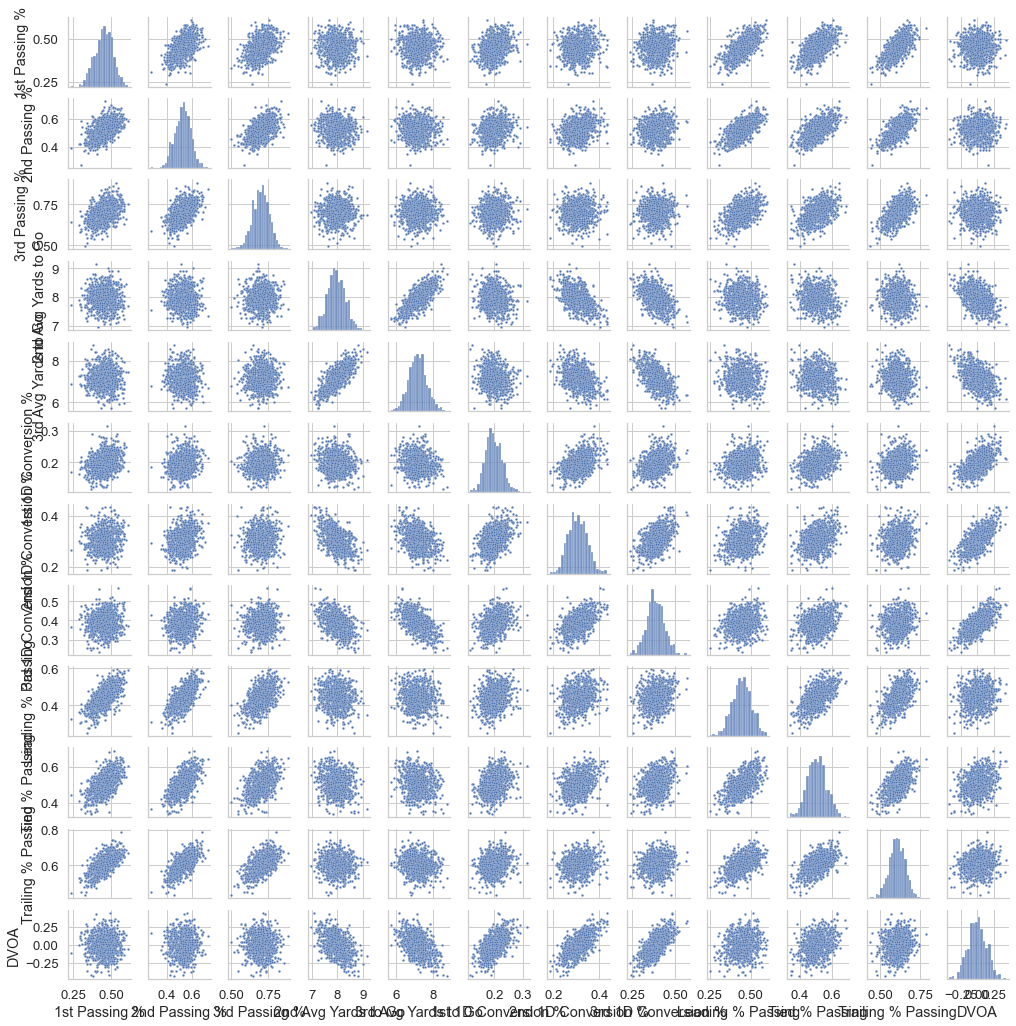

<Figure size 432x288 with 0 Axes>

In [7]:
#sns_pairplot = sns.pairplot(nfl_df.iloc[:, 2:14], height=1.2, plot_kws={'s': 6})
#sns_pairplot.savefig("pairplot.png")

plt.clf() # Clean parirplot figure from sns 
Image(filename='pairplot.png') # Show pairplot as image

In [8]:
# Various column names to distinguish them in the figure above
nfl_df.columns.values[2:12]

array(['1st Passing %', '2nd Passing %', '3rd Passing %',
       '2nd Avg Yards to Go', '3rd Avg Yards to Go',
       '1st 1D Conversion %', '2nd 1D Conversion %',
       '3rd 1D Conversion %', 'Leading % Passing', 'Tied % Passing'],
      dtype=object)

In [9]:
nfl_df.corr()

,Year,1st Passing %,2nd Passing %,3rd Passing %,2nd Avg Yards to Go,3rd Avg Yards to Go,1st 1D Conversion %,2nd 1D Conversion %,3rd 1D Conversion %,Leading % Passing,Tied % Passing,Trailing % Passing,DVOA
Year,1.000000,0.117046,0.296150,0.134102,-0.062415,-0.085915,0.298967,0.281525,0.099731,0.184760,0.223367,0.124799,-0.004174
1st Passing %,0.117046,1.000000,0.531562,0.411240,-0.006000,-0.007700,0.275835,0.097936,0.060968,0.679191,0.603639,0.689392,0.002668
2nd Passing %,0.296150,0.531562,1.000000,0.523001,-0.048176,-0.049954,0.189971,0.285372,0.133621,0.689099,0.622678,0.697461,0.022875
3rd Passing %,0.134102,0.411240,0.523001,1.000000,0.044753,0.046846,0.079352,0.071818,0.042347,0.532961,0.483477,0.586401,-0.029616
2nd Avg Yards to Go,-0.062415,-0.006000,-0.048176,0.044753,1.000000,0.739511,-0.147206,-0.538041,-0.464178,-0.100439,-0.190426,-0.071103,-0.489024
3rd Avg Yards to Go,-0.085915,-0.007700,-0.049954,0.046846,0.739511,1.000000,-0.151604,-0.352281,-0.540812,-0.073474,-0.177944,-0.112772,-0.473233
1st 1D Conversion %,0.298967,0.275835,0.189971,0.079352,-0.147206,-0.151604,1.000000,0.470129,0.360268,0.261767,0.328189,0.230352,0.565644
2nd 1D Conversion %,0.281525,0.097936,0.285372,0.071818,-0.538041,-0.352281,0.470129,1.000000,0.503720,0.278909,0.355049,0.215843,0.677213
3rd 1D Conversion %,0.099731,0.060968,0.133621,0.042347,-0.464178,-0.540812,0.360268,0.503720,1.000000,0.215365,0.304841,0.164002,0.709432
Leading % Passing,0.184760,0.679191,0.689099,0.532961,-0.100439,-0.073474,0.261767,0.278909,0.215365,1.000000,0.612299,0.556702,0.160687


In [10]:
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [11]:
vif(nfl_df.iloc[:, 2:13])

1st Passing %          204.739966
2nd Passing %          217.399307
3rd Passing %          292.224708
2nd Avg Yards to Go    834.382231
3rd Avg Yards to Go    577.366239
1st 1D Conversion %     68.182524
2nd 1D Conversion %    100.350148
3rd 1D Conversion %    100.040811
Leading % Passing      193.006680
Tied % Passing         180.616452
Trailing % Passing     495.667871
dtype: float64

In [12]:
# Dropped some columns to reduce multicollinearity
vif(nfl_df[['1st Passing %', '3rd Avg Yards to Go', '1st 1D Conversion %', '2nd 1D Conversion %', '3rd 1D Conversion %']])
    

1st Passing %          62.868289
3rd Avg Yards to Go    62.124925
1st 1D Conversion %    66.166679
2nd 1D Conversion %    82.797156
3rd 1D Conversion %    72.653340
dtype: float64

# Linear Regression (Baseline & Best)

In [13]:
# Split into train, val, and test
X, X_test, y, y_test = train_test_split(nfl_df[['1st Passing %', '2nd Passing %', '3rd Passing %', '2nd Avg Yards to Go', '3rd Avg Yards to Go', '1st 1D Conversion %', '2nd 1D Conversion %', '3rd 1D Conversion %', 'Leading % Passing', 'Tied % Passing', 'Trailing % Passing']], 
                                        nfl_df['DVOA'], test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

In [14]:
# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.7926352551252742

In [15]:
# Score on validation set
lr.score(X_val,y_val)

0.7722806246020978

In [16]:
lr.score(X_test,y_test)

0.7288741805126354

In [17]:
list(zip(X_train.columns, lr.coef_))

[('1st Passing %', -0.9313559370363161),
 ('2nd Passing %', -0.9540839841124419),
 ('3rd Passing %', -0.40140518875667497),
 ('2nd Avg Yards to Go', -0.017964982034522403),
 ('3rd Avg Yards to Go', -0.013829286101406116),
 ('1st 1D Conversion %', 1.4825596775745231),
 ('2nd 1D Conversion %', 0.9652005655780633),
 ('3rd 1D Conversion %', 1.0228422977728668),
 ('Leading % Passing', 0.4920840321995274),
 ('Tied % Passing', 0.591383631755214),
 ('Trailing % Passing', 1.0174272933024917)]

Text(0.5, 1.0, 'Linear Regression Predicted vs Actual DVOA')

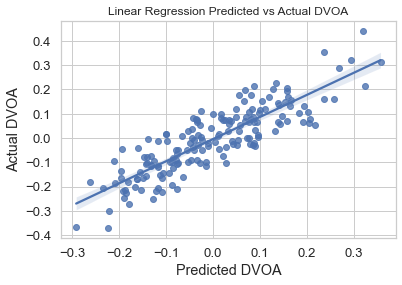

In [18]:
lr_pred = lr.predict(X_test)
ax = sns.regplot(x = lr_pred, y = y_test, data=nfl_df);
sns.set(rc={'figure.figsize':(10,10)})
ax.set(xlabel='Predicted DVOA', ylabel='Actual DVOA')
ax.set_title('Linear Regression Predicted vs Actual DVOA')
#plt.savefig('lr.jpg', dpi = 1500, quality = 90, edgecolor ='b')

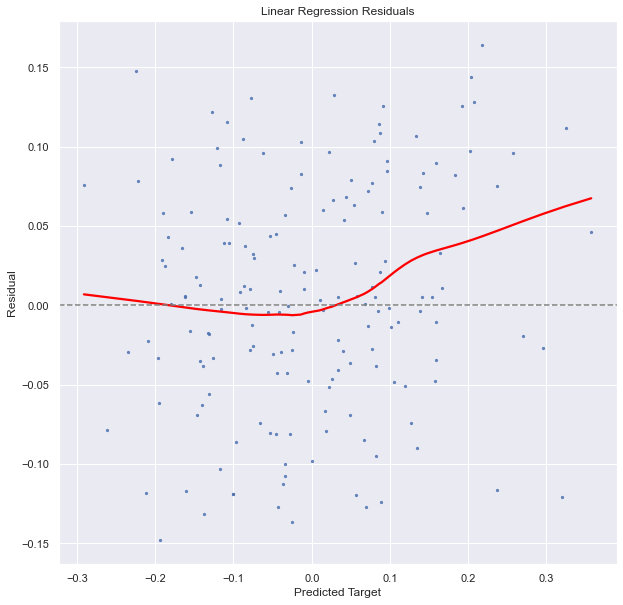

In [19]:
resid = lr_pred - y_test

g2 = sns.regplot(x=lr_pred, y=resid, lowess=True, line_kws={'color': 'red'}, scatter_kws={'s': 5})
g2.set_xlabel('Predicted Target')
g2.set_ylabel('Residual')
g2.set_title('Linear Regression Residuals')
g2.axhline(y=0, color='gray', linestyle='--')


#plt.savefig('resid.jpeg', dpi = 1500, quality = 90, edgecolor ='b')

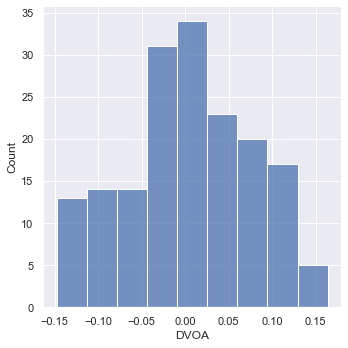

In [20]:
g2 = sns.displot(resid)
#plt.savefig('resid2.jpeg', dpi = 1500, quality = 90, edgecolor ='b')

In [21]:
# Teams we are underestimating
nfl_df['res'] = lr.predict(nfl_df[['1st Passing %', '2nd Passing %', '3rd Passing %', '2nd Avg Yards to Go', '3rd Avg Yards to Go', '1st 1D Conversion %', '2nd 1D Conversion %', '3rd 1D Conversion %', 'Leading % Passing', 'Tied % Passing', 'Trailing % Passing']])-nfl_df['DVOA']
nfl_df.sort_values(['res']).head()

,Team,Year,1st Passing %,2nd Passing %,3rd Passing %,2nd Avg Yards to Go,3rd Avg Yards to Go,1st 1D Conversion %,2nd 1D Conversion %,3rd 1D Conversion %,Leading % Passing,Tied % Passing,Trailing % Passing,DVOA,res
833,Los Angeles Chargers,2003,0.433180,0.598131,0.685279,8.70,7.62,0.218894,0.305296,0.319797,0.435407,0.405797,0.605769,0.037,-0.203593
7,Arizona Cardinals,2001,0.477435,0.526814,0.739796,8.43,7.98,0.190024,0.337539,0.290816,0.462687,0.518750,0.606464,0.054,-0.176173
557,Cincinnati Bengals,1997,0.427586,0.503012,0.679070,8.30,6.92,0.197701,0.292169,0.409302,0.442359,0.488764,0.563193,0.180,-0.174645
732,New England Patriots,2010,0.402715,0.537538,0.729592,7.67,7.17,0.214932,0.366366,0.484694,0.465986,0.631579,0.564394,0.428,-0.173258
505,Cleveland Browns,1999,0.486339,0.580986,0.707921,8.69,8.41,0.188525,0.246479,0.292079,0.461538,0.491803,0.613288,-0.113,-0.165354


In [22]:
# Teams we are overestimated
nfl_df.sort_values(['res']).tail()

,Team,Year,1st Passing %,2nd Passing %,3rd Passing %,2nd Avg Yards to Go,3rd Avg Yards to Go,1st 1D Conversion %,2nd 1D Conversion %,3rd 1D Conversion %,Leading % Passing,Tied % Passing,Trailing % Passing,DVOA,res
24,Arizona Cardinals,2018,0.487179,0.527027,0.695000,8.43,8.23,0.187179,0.260135,0.290000,0.462810,0.472727,0.586992,-0.418,0.174342
290,Atlanta Falcons,2015,0.492754,0.578947,0.745614,7.88,6.75,0.233954,0.286550,0.469298,0.472603,0.588496,0.627027,-0.072,0.175896
36,Los Angeles Rams,2003,0.497917,0.553936,0.754630,8.17,7.36,0.231250,0.297376,0.425926,0.504604,0.522727,0.698507,-0.070,0.187342
78,San Francisco 49ers,2018,0.449580,0.570988,0.663212,8.21,7.63,0.262605,0.311728,0.378238,0.466454,0.490566,0.580038,-0.158,0.189570
362,Indianapolis Colts,2014,0.501976,0.632153,0.764977,7.72,6.65,0.223320,0.346049,0.414747,0.520067,0.603093,0.744409,-0.013,0.191311


In [23]:
# Best DVOA Teams
nfl_df.sort_values(['DVOA']).tail()

,Team,Year,1st Passing %,2nd Passing %,3rd Passing %,2nd Avg Yards to Go,3rd Avg Yards to Go,1st 1D Conversion %,2nd 1D Conversion %,3rd 1D Conversion %,Leading % Passing,Tied % Passing,Trailing % Passing,DVOA,res
112,Denver Broncos,1998,0.385928,0.481586,0.657005,7.74,6.95,0.226013,0.356941,0.434783,0.436202,0.539267,0.540230,0.350,-0.132875
170,Kansas City Chiefs,2002,0.445175,0.468354,0.645161,7.60,6.40,0.278509,0.373418,0.419355,0.425770,0.482353,0.548753,0.354,-0.116723
186,Kansas City Chiefs,2018,0.525988,0.616099,0.706215,7.89,6.95,0.266112,0.405573,0.468927,0.534483,0.614525,0.687764,0.354,-0.033817
732,New England Patriots,2010,0.402715,0.537538,0.729592,7.67,7.17,0.214932,0.366366,0.484694,0.465986,0.631579,0.564394,0.428,-0.173258
729,New England Patriots,2007,0.491701,0.561983,0.713542,7.08,6.17,0.211618,0.432507,0.479167,0.513120,0.630573,0.627907,0.441,-0.121098


In [24]:
# Worst DVOA Teams
nfl_df.sort_values(['DVOA']).head()

,Team,Year,1st Passing %,2nd Passing %,3rd Passing %,2nd Avg Yards to Go,3rd Avg Yards to Go,1st 1D Conversion %,2nd 1D Conversion %,3rd 1D Conversion %,Leading % Passing,Tied % Passing,Trailing % Passing,DVOA,res
323,Houston Texans,2002,0.383420,0.459119,0.646288,8.81,8.77,0.121762,0.226415,0.257642,0.335821,0.393035,0.527778,-0.433,0.023533
24,Arizona Cardinals,2018,0.487179,0.527027,0.695000,8.43,8.23,0.187179,0.260135,0.290000,0.462810,0.472727,0.586992,-0.418,0.174342
65,San Francisco 49ers,2005,0.367978,0.420339,0.637255,8.64,8.55,0.115169,0.240678,0.245098,0.423313,0.344262,0.478343,-0.412,0.018713
49,Los Angeles Rams,2016,0.436275,0.589905,0.734884,8.32,7.29,0.166667,0.255521,0.311628,0.444444,0.570175,0.595506,-0.381,0.168238
147,Las Vegas Raiders,2006,0.398010,0.535032,0.669811,8.58,8.02,0.134328,0.254777,0.363208,0.450777,0.439614,0.555556,-0.372,0.147938


# Lasso

In [25]:
# Scale the data as before
std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [26]:
# Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [27]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [28]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

0.01

In [29]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

[('1st Passing %', -0.004036365876125752),
 ('2nd Passing %', -0.011630601418644497),
 ('3rd Passing %', -0.0),
 ('2nd Avg Yards to Go', -0.006974970486542385),
 ('3rd Avg Yards to Go', -0.004000932201304448),
 ('1st 1D Conversion %', 0.03559505207854312),
 ('2nd 1D Conversion %', 0.040290841782677445),
 ('3rd 1D Conversion %', 0.05669050528704179),
 ('Leading % Passing', -0.0),
 ('Tied % Passing', 0.0),
 ('Trailing % Passing', 0.0)]

In [30]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

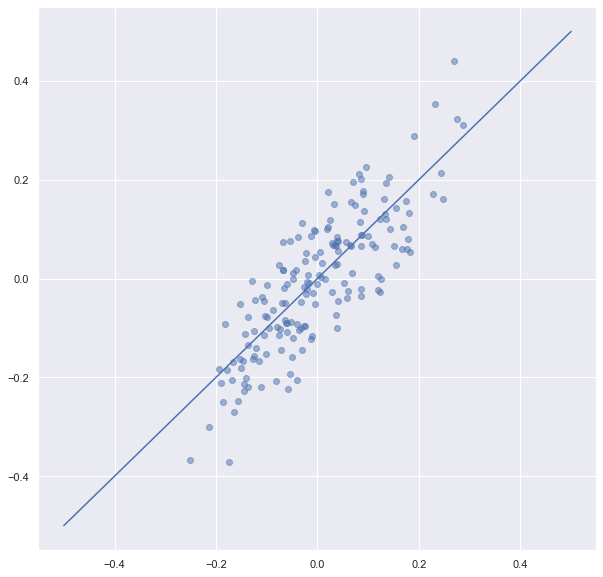

In [31]:
test_set_pred = lasso_model.predict(X_te)
plt.scatter(test_set_pred, y_test, alpha=.5)
plt.plot(np.linspace(-.5,.5), np.linspace(-.5,.5))

In [32]:
from sklearn.linear_model import lars_path
## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

Computing regularization path using the LARS ...


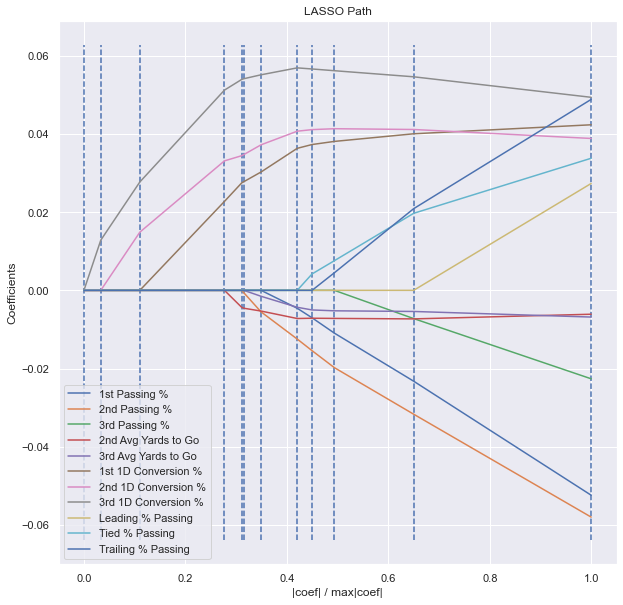

In [33]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

# Polynomial Regression

In [34]:
# Try polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
lr_poly.score(X_train_poly,y_train)

0.829174292627966

In [35]:
# Score on validation set (overfit!)
lr_poly.score(X_val_poly, y_val)

0.7025097958218366

In [36]:
X_test_poly = poly.fit_transform(X_test)
lr_poly.score(X_test_poly, y_test)

0.7088643278361177

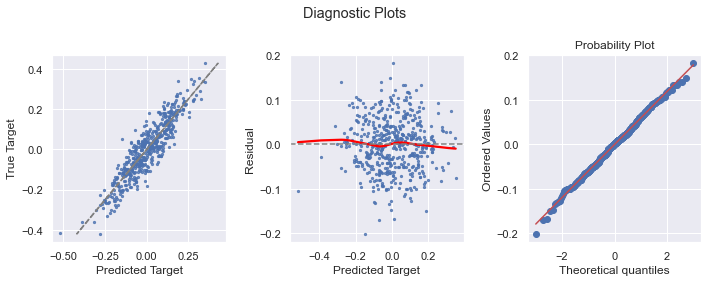

In [37]:
diagnostic_plots(lr_poly.predict(X_train_poly), y_train)

## Polynomial Lasso Regression

In [38]:
# Don't forget to standard scale your data for regularized regression
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Apply the same scaler to val set
X_val_poly_scaled = scaler.transform(X_val_poly)

# Fit a LASSO model using polynomial features for various alphas
print("\t\tTrain\tTest")

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 2]
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_poly_scaled,y_train)
    print(f"alpha={alpha}: \t{lasso.score(X_train_poly_scaled,y_train):.4f} \t{lasso.score(X_val_poly_scaled,y_val):.4f}")

		Train	Test
alpha=0.0001: 	0.8068 	0.7603
alpha=0.001: 	0.7957 	0.7685
alpha=0.01: 	0.7286 	0.7534
alpha=0.1: 	0.1317 	0.1549
alpha=1: 	0.0000 	-0.0079
alpha=2: 	0.0000 	-0.0079


/Users/michaelkamel/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3130536067351538, tolerance: 0.0010534997664705882
  model = cd_fast.enet_coordinate_descent(
/Users/michaelkamel/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011747135991906354, tolerance: 0.0010534997664705882
  model = cd_fast.enet_coordinate_descent(


In [39]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_train_poly_scaled,y_train)

/Users/michaelkamel/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011747135991906354, tolerance: 0.0010534997664705882
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.001)

In [40]:
list(zip(poly.get_feature_names(['1st Passing %', '2nd Passing %', '3rd Passing %', '2nd Avg Yards to Go', '3rd Avg Yards to Go', '1st 1D Conversion %', '2nd 1D Conversion %', '3rd 1D Conversion %', 'Leading % Passing', 'Tied % Passing', 'Trailing % Passing']),lasso.coef_))

[('1', 0.0),
 ('1st Passing %', -0.0),
 ('2nd Passing %', -0.0),
 ('3rd Passing %', -0.0),
 ('2nd Avg Yards to Go', -0.0),
 ('3rd Avg Yards to Go', -0.0),
 ('1st 1D Conversion %', 0.0),
 ('2nd 1D Conversion %', 0.0),
 ('3rd 1D Conversion %', 0.0),
 ('Leading % Passing', 0.0),
 ('Tied % Passing', 0.008011720933763275),
 ('Trailing % Passing', 0.035833726275367815),
 ('1st Passing %^2', -0.0),
 ('1st Passing % 2nd Passing %', -0.045992166164040386),
 ('1st Passing % 3rd Passing %', -0.011938752783549677),
 ('1st Passing % 2nd Avg Yards to Go', -0.0),
 ('1st Passing % 3rd Avg Yards to Go', -0.009820701827613559),
 ('1st Passing % 1st 1D Conversion %', -0.0),
 ('1st Passing % 2nd 1D Conversion %', -0.0),
 ('1st Passing % 3rd 1D Conversion %', -0.0),
 ('1st Passing % Leading % Passing', 0.0),
 ('1st Passing % Tied % Passing', -0.0),
 ('1st Passing % Trailing % Passing', -0.0),
 ('2nd Passing %^2', -0.0),
 ('2nd Passing % 3rd Passing %', -0.0),
 ('2nd Passing % 2nd Avg Yards to Go', -0.02658

In [41]:
# Fit a LASSO model on full dataset using scaled, polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

lasso = Lasso(alpha=0.001)
lasso.fit(X_poly_scaled,y)

# Apply the same polynomial and scaling transformations to test set, then score
X_test_poly = poly.transform(X_test)
X_test_poly_scaled = scaler.transform(X_test_poly)

lasso.score(X_test_poly_scaled, y_test)

0.7344018037805979

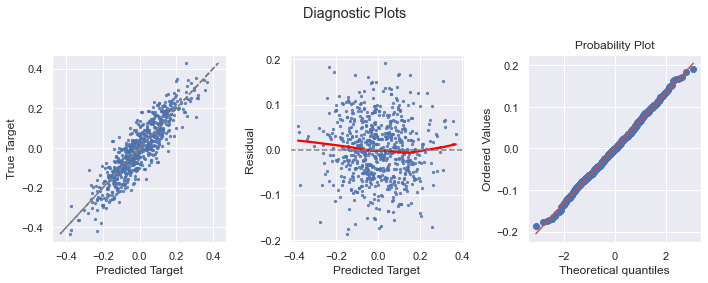

In [42]:
diagnostic_plots(lasso.predict(X_poly_scaled), y)

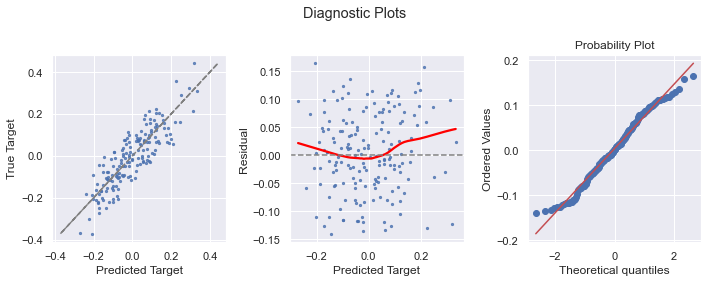

In [43]:
diagnostic_plots(lasso.predict(X_test_poly_scaled), y_test)

# Cross Validation Testing

In [44]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)
lm_reg2 = Lasso(alpha=.001)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [45]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_reg2.fit(X_train_scaled, y_train)
print(f'Lasso Regression val R^2: {lm_reg2.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.772
Ridge Regression val R^2: 0.773
Lasso Regression val R^2: 0.780
Degree 2 polynomial regression val R^2: 0.703


In [46]:
lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

lm_reg.fit(scaler.fit_transform(X.values), y)
print(f'Ridge Regression val R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

lm_reg2.fit(scaler.fit_transform(X.values), y)
print(f'Lasso Regression val R^2: {lm_reg2.score(X_test_scaled, y_test):.3f}')

Linear Regression test R^2: 0.734
Ridge Regression val R^2: 0.731
Lasso Regression val R^2: 0.730


In [47]:
# diagnostic_plots(lm.predict(X_test), y_test)

In [48]:
X, y = nfl_df[['1st Passing %', '2nd Passing %', '3rd Passing %', '2nd Avg Yards to Go', '3rd Avg Yards to Go', '1st 1D Conversion %', '2nd 1D Conversion %', '3rd 1D Conversion %', 'Leading % Passing', 'Tied % Passing', 'Trailing % Passing']], nfl_df['DVOA']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [49]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val).round(3))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val).round(3))

print(f'Simple scores: \t{cv_lm_r2s}')
print(f'Ridge scores: \t{cv_lm_reg_r2s} \n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple scores: 	[0.81, 0.796, 0.749, 0.806, 0.705]
Ridge scores: 	[0.81, 0.795, 0.75, 0.806, 0.705] 

Simple mean cv r^2: 0.773 +- 0.040
Ridge mean cv r^2: 0.773 +- 0.040


In [50]:
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.71925431, 0.81171392, 0.7796101 , 0.81480425, 0.73542736])

In [51]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([0.80957474, 0.79551336, 0.74949717, 0.80550052, 0.7050543 ])

In [52]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.7733831209218491
0.6496536144041578


# Cross Validation - LR, Lasso, Ridge

In [53]:
X_train, X_holdout, y_train, y_holdout = train_test_split(nfl_df[['1st Passing %', '2nd Passing %', '3rd Passing %', '2nd Avg Yards to Go', '3rd Avg Yards to Go', '1st 1D Conversion %', '2nd 1D Conversion %', '3rd 1D Conversion %', 'Leading % Passing', 'Tied % Passing', 'Trailing % Passing']], nfl_df['DVOA'], test_size=0.1, random_state=42)


In [54]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [55]:
lin_reg_est = LinearRegression()

scores = cross_val_score(lin_reg_est, X_train, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))

# Build the Model
lin_reg_est.fit(X_train, y_train)

[0.78081136 0.75854098 0.79342117 0.76264491 0.73812835]
Linear Reg Mean Score:  0.7667093529536713


LinearRegression()

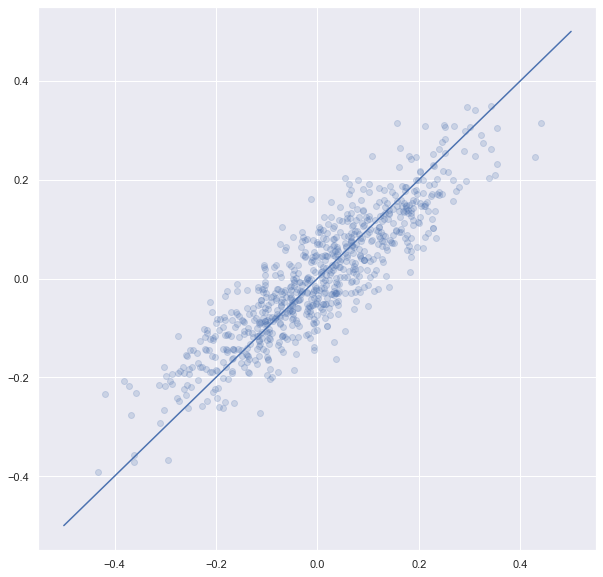

In [56]:
#Fitted vs. Actual
y_train_pred = lin_reg_est.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([-.5, .5], [-.5, .5])

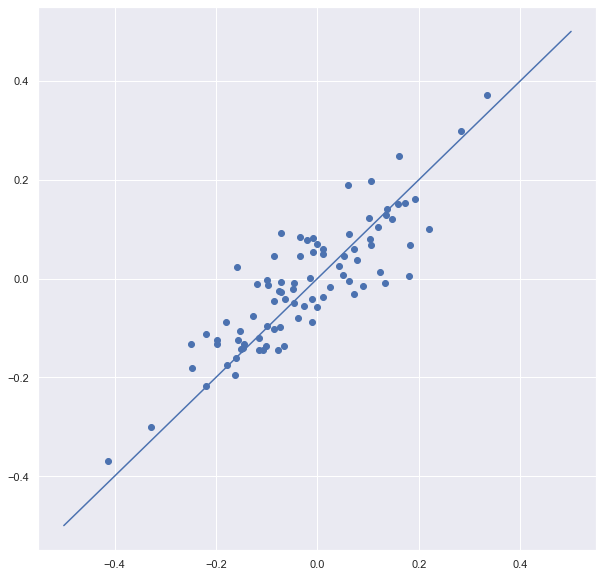

In [57]:
# Fitted vs. Actual
y_test_pred = lin_reg_est.predict(X_holdout)

plt.scatter(y_holdout, y_test_pred)
plt.plot([-.5, .5], [-.5, .5])

Text(0.5, 1.0, 'Residuals vs. Predictions')

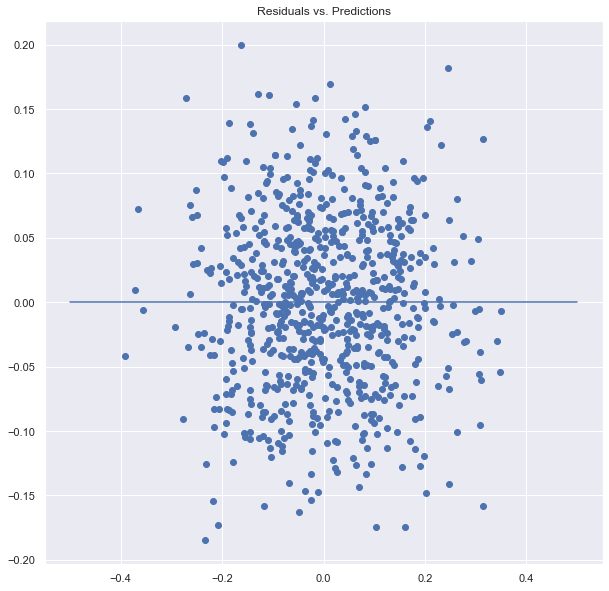

In [58]:
# Plot Residuals vs. predicted

lin_reg_residuals = y_train - y_train_pred

plt.scatter(y_train_pred, lin_reg_residuals)
plt.plot([-.5,.5], [0, 0])
plt.title("Residuals vs. Predictions")

Lasso Model:


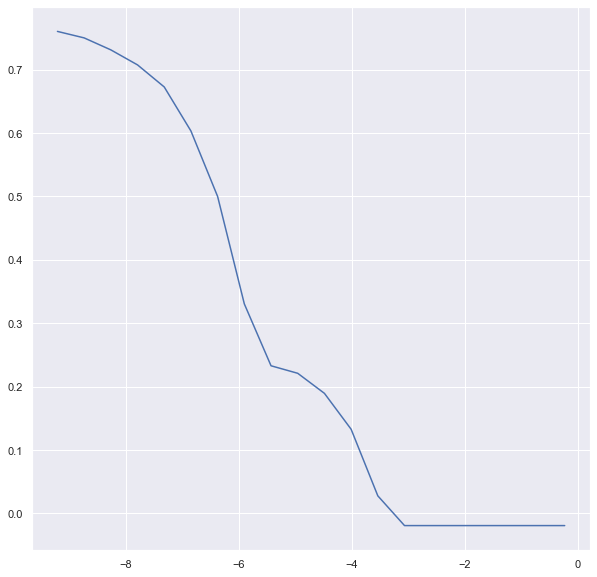

In [59]:
print("Lasso Model:")
params = {
    "alpha": np.logspace(-4, -.1, 20)
}

grid_est = GridSearchCV(Lasso(), param_grid=params, cv=kfold, 
                        return_train_score=False)
grid_est.fit(X_train, y_train)
df = pd.DataFrame(grid_est.cv_results_)
df["alpha"] = df.params.apply(lambda val: val["alpha"])
plt.plot(np.log(df.alpha), df.mean_test_score);

In [60]:
grid_est.best_estimator_

Lasso(alpha=0.0001)

In [61]:
params['alpha']

array([1.00000000e-04, 1.60421716e-04, 2.57351270e-04, 4.12847324e-04,
       6.62296762e-04, 1.06246783e-03, 1.70442913e-03, 2.73427446e-03,
       4.38637001e-03, 7.03669004e-03, 1.12883789e-02, 1.81090112e-02,
       2.90507865e-02, 4.66037703e-02, 7.47625680e-02, 1.19935395e-01,
       1.92402418e-01, 3.08655261e-01, 4.95150067e-01, 7.94328235e-01])

Ridge Model:


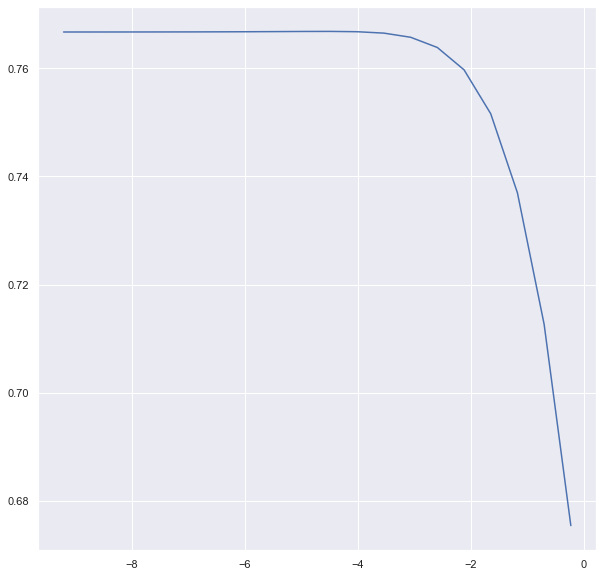

In [62]:
print("Ridge Model:")
params = {
    "alpha": np.logspace(-4, -.1, 20)
}

grid_est = GridSearchCV(Ridge(), param_grid=params, cv=kfold, 
                        return_train_score=False)
grid_est.fit(X_train, y_train)
df = pd.DataFrame(grid_est.cv_results_)
df["alpha"] = df.params.apply(lambda val: val["alpha"])
plt.plot(np.log(df.alpha), df.mean_test_score);

In [63]:
def build_grid_search_est(model, X, y, cv=5, **params):

    grid_est = GridSearchCV(model, param_grid=params, cv=kfold, 
                            return_train_score=False)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.cv_results_)
    for param in params:
        df[param] = df.params.apply(lambda val: val[param])
#       plt.plot(np.log(df.alpha), df.mean_test_score);
        plt.semilogx(df.alpha, df.mean_test_score)
    return grid_est

Lasso Grid Search


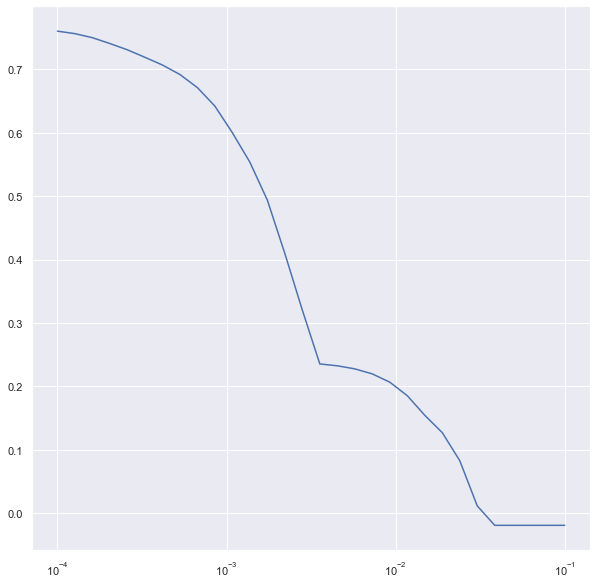

In [64]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_train, y_train, cv=kfold,
                                       alpha=np.logspace(-4, -1, 30))

Ridge Grid Search


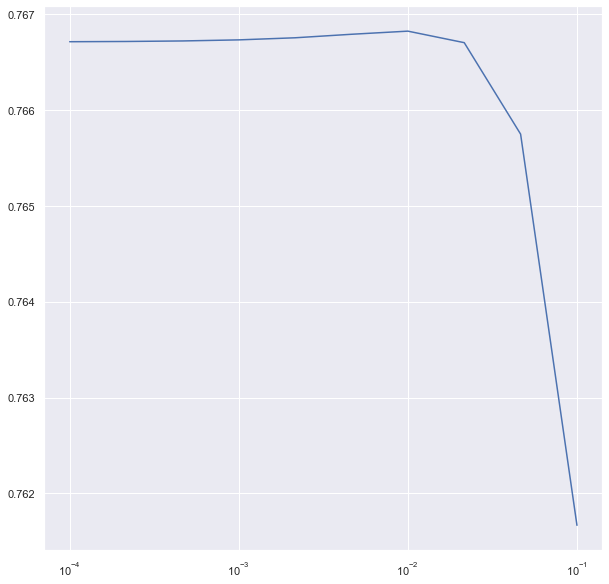

In [65]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_train, y_train, cv=kfold,
                                       alpha=np.logspace(-4, -1, 10))

In [66]:
y_pred = lin_reg_est.predict(X_holdout)
print("Linear Regression:", r2_score(y_holdout, y_pred))

y_pred = lasso_grid_est.predict(X_holdout)
print("Lasso Regression:", r2_score(y_holdout, y_pred))

y_pred = ridge_grid_est.predict(X_holdout)
print("Ridge Regression:", r2_score(y_holdout, y_pred))

Linear Regression: 0.7358996859731479
Lasso Regression: 0.731136854740235
Ridge Regression: 0.7360671028335407


In [67]:
pd.DataFrame(list(zip(X_train, lasso_grid_est.best_estimator_.coef_)))

,0,1
0,1st Passing %,-0.561884
1,2nd Passing %,-0.754963
2,3rd Passing %,-0.184642
3,2nd Avg Yards to Go,-0.015693
4,3rd Avg Yards to Go,-0.018377
5,1st 1D Conversion %,1.264237
6,2nd 1D Conversion %,1.055937
7,3rd 1D Conversion %,0.989918
8,Leading % Passing,0.242001
9,Tied % Passing,0.454643


In [68]:
poly = PolynomialFeatures()

lm_poly = LinearRegression()
lm_poly.fit(poly.fit_transform(X_train), y_train)
y_pred = lm_poly.predict(poly.transform(X_holdout))
print("Polynomial Regression:", r2_score(y_holdout, y_pred))

Polynomial Regression: 0.6761126667631918


In [69]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(n_estimators=2000, max_features=3, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_holdout)
print("Random Forest Regression:", r2_score(y_holdout, y_pred))

gbm = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.01)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_holdout)
print("Gradient Boosted Regression:", r2_score(y_holdout, y_pred))

Random Forest Regression: 0.6281572454811212
Gradient Boosted Regression: 0.6840618088466326


# Feature Engineering

In [70]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

In [71]:
X, y = nfl_df[['1st Passing %', '2nd Passing %', '3rd Passing %', '2nd Avg Yards to Go', '3rd Avg Yards to Go', '1st 1D Conversion %', '2nd 1D Conversion %', '3rd 1D Conversion %', 'Leading % Passing', 'Tied % Passing', 'Trailing % Passing']], nfl_df['DVOA']

In [72]:
split_and_validate(X,y)


Validation R^2 score was: 0.7603491729945975
Feature coefficient results: 

1st Passing % : -0.85
2nd Passing % : -0.96
3rd Passing % : -0.34
2nd Avg Yards to Go : -0.01
3rd Avg Yards to Go : -0.01
1st 1D Conversion % : 1.34
2nd 1D Conversion % : 1.03
3rd 1D Conversion % : 0.97
Leading % Passing : 0.50
Tied % Passing : 0.56
Trailing % Passing : 0.87


In [73]:
X2 = X.copy()

In [74]:
# Failed attempts
#X2['Passing'] = X2['1st Passing %'] + X2['2nd Passing %'] + X2['3rd Passing %'] + X2['Leading % Passing'] + X2['Tied % Passing'] + X2['Trailing % Passing']
#X2['1D Conversion %'] = X2['1st 1D Conversion %'] + X2['2nd 1D Conversion %'] + X2['3rd 1D Conversion %']         

In [75]:
X2['2nd Down Efficiency'] = X2['2nd 1D Conversion %'] / X2['2nd Avg Yards to Go']

In [76]:
X2['3rd Down Efficiency'] = X2['3rd 1D Conversion %'] / X2['3rd Avg Yards to Go']

In [77]:
X2

,1st Passing %,2nd Passing %,3rd Passing %,2nd Avg Yards to Go,3rd Avg Yards to Go,1st 1D Conversion %,2nd 1D Conversion %,3rd 1D Conversion %,Leading % Passing,Tied % Passing,Trailing % Passing,2nd Down Efficiency,3rd Down Efficiency
0,0.375000,0.509915,0.793860,8.51,8.07,0.192982,0.263456,0.337719,0.397380,0.451737,0.584369,0.030958,0.041849
1,0.436652,0.584570,0.768116,7.96,7.83,0.171946,0.299703,0.342995,0.559441,0.463415,0.584356,0.037651,0.043805
2,0.525386,0.552023,0.736842,8.04,7.24,0.185430,0.268786,0.421053,0.443966,0.513369,0.651200,0.033431,0.058156
3,0.543290,0.504323,0.669421,8.90,8.22,0.199134,0.230548,0.359504,0.477528,0.502283,0.600000,0.025904,0.043735
4,0.454936,0.505780,0.703196,7.57,6.99,0.203863,0.289017,0.347032,0.446203,0.498127,0.596567,0.038179,0.049647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,0.435345,0.642012,0.765000,7.99,6.78,0.217672,0.343195,0.425000,0.524752,0.531792,0.631579,0.042953,0.062684
847,0.446121,0.601190,0.808612,8.43,7.23,0.245690,0.321429,0.401914,0.498708,0.553191,0.653266,0.038129,0.055590
848,0.434590,0.553398,0.796610,7.91,7.35,0.279379,0.362460,0.384181,0.474041,0.558333,0.615183,0.045823,0.052269
849,0.498901,0.642424,0.757732,7.78,7.22,0.224176,0.339394,0.443299,0.505495,0.548780,0.658929,0.043624,0.061399


In [78]:
split_and_validate(X2,y)


Validation R^2 score was: 0.7627545252303543
Feature coefficient results: 

1st Passing % : -0.84
2nd Passing % : -0.95
3rd Passing % : -0.34
2nd Avg Yards to Go : 0.00
3rd Avg Yards to Go : -0.05
1st 1D Conversion % : 1.34
2nd 1D Conversion % : 0.73
3rd 1D Conversion % : 1.61
Leading % Passing : 0.50
Tied % Passing : 0.55
Trailing % Passing : 0.86
2nd Down Efficiency : 2.43
3rd Down Efficiency : -4.60


In [79]:
X3 = X.copy()

In [80]:
X3['Passing'] = (X3['1st Passing %'] + X3['2nd Passing %'] + X3['3rd Passing %']) / 3

In [81]:
X3

,1st Passing %,2nd Passing %,3rd Passing %,2nd Avg Yards to Go,3rd Avg Yards to Go,1st 1D Conversion %,2nd 1D Conversion %,3rd 1D Conversion %,Leading % Passing,Tied % Passing,Trailing % Passing,Passing
0,0.375000,0.509915,0.793860,8.51,8.07,0.192982,0.263456,0.337719,0.397380,0.451737,0.584369,0.559592
1,0.436652,0.584570,0.768116,7.96,7.83,0.171946,0.299703,0.342995,0.559441,0.463415,0.584356,0.596446
2,0.525386,0.552023,0.736842,8.04,7.24,0.185430,0.268786,0.421053,0.443966,0.513369,0.651200,0.604751
3,0.543290,0.504323,0.669421,8.90,8.22,0.199134,0.230548,0.359504,0.477528,0.502283,0.600000,0.572345
4,0.454936,0.505780,0.703196,7.57,6.99,0.203863,0.289017,0.347032,0.446203,0.498127,0.596567,0.554637
...,...,...,...,...,...,...,...,...,...,...,...,...
846,0.435345,0.642012,0.765000,7.99,6.78,0.217672,0.343195,0.425000,0.524752,0.531792,0.631579,0.614119
847,0.446121,0.601190,0.808612,8.43,7.23,0.245690,0.321429,0.401914,0.498708,0.553191,0.653266,0.618641
848,0.434590,0.553398,0.796610,7.91,7.35,0.279379,0.362460,0.384181,0.474041,0.558333,0.615183,0.594866
849,0.498901,0.642424,0.757732,7.78,7.22,0.224176,0.339394,0.443299,0.505495,0.548780,0.658929,0.633019


In [82]:
X3.drop(columns = ['2nd Passing %', '3rd Passing %', 'Leading % Passing', 'Tied % Passing', 'Trailing % Passing', '2nd Avg Yards to Go', '3rd Avg Yards to Go'], inplace = True)


In [83]:
split_and_validate(X3,y)


Validation R^2 score was: 0.7075367022922968
Feature coefficient results: 

1st Passing % : 0.04
1st 1D Conversion % : 1.35
2nd 1D Conversion % : 1.21
3rd 1D Conversion % : 1.28
Passing : -0.60
